## Spearman's rho from different MSAs are highly correlated

In [1]:
from scipy.stats import pearsonr
from scipy.spatial.distance import squareform
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

Mounted at /content/drive
/usr/share/fonts: caching, new cache contents: 0 fonts, 1 dirs
/usr/share/fonts/truetype: caching, new cache contents: 0 fonts, 2 dirs
/usr/share/fonts/truetype/humor-sans: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype/liberation: caching, new cache contents: 16 fonts, 0 dirs
/usr/local/share/fonts: caching, new cache contents: 0 fonts, 0 dirs
/root/.local/share/fonts: skipping, no such directory
/root/.fonts: caching, new cache contents: 1 fonts, 0 dirs
/usr/share/fonts/truetype: skipping, looped directory detected
/usr/share/fonts/truetype/humor-sans: skipping, looped directory detected
/usr/share/fonts/truetype/liberation: skipping, looped directory detected
/var/cache/fontconfig: cleaning cache directory
/root/.cache/fontconfig: not cleaning non-existent cache directory
/root/.fontconfig: not cleaning non-existent cache directory
fc-cache: succeeded


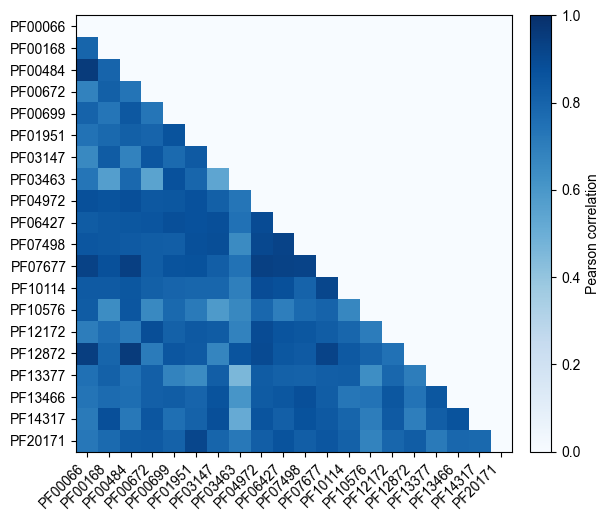

In [2]:
def correlated_rho(domain_name):

  base_path = 'Results'
  default_dict = {}

  default_corr_file = os.path.join(base_path, f'{domain_name}_default_ev_analysis_col_attention.csv')
  if os.path.exists(default_corr_file):
    default_corr = pd.read_csv(default_corr_file)["Correlation"].to_numpy().reshape(12, 12)

  return default_corr

def cal_pearsons():

  pearsons_coeffs = []
  for i, pfam_family_x in enumerate(protein_domain_list):
    for pfam_family_y in protein_domain_list[i + 1:]:
        x = correlated_rho(pfam_family_x).flatten()
        y = correlated_rho(pfam_family_y).flatten()

        pearsons_coeffs.append(pearsonr(x, y)[0])
  pearsons_coeffs = squareform(np.array(pearsons_coeffs))

  return pearsons_coeffs


with open('./data/Pfam/protein_domain.txt', 'r') as file:
  lines = file.readlines()
protein_domain_list = [line.strip() for line in lines]
pearsons_coeffs = cal_pearsons()

labels = [pfam_family for i, pfam_family in enumerate(protein_domain_list)]

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['arial']
fig, ax = plt.subplots(figsize=(6, 6),
                       constrained_layout=True)
im = ax.imshow(np.tril(pearsons_coeffs),
               cmap='Blues',
               aspect="equal",
               vmin=0, vmax=1)
ax.set_yticks(np.arange(len(protein_domain_list)),
              labels=labels)
ax.set_xticks(np.arange(len(protein_domain_list)),
              labels=labels,
              rotation=45,
              ha="right")
fig.colorbar(im, ax=ax, fraction=0.05, pad=0.04, label="Pearson correlation")

plt.show()

## The similarity scores from different MSAs are highly correlated

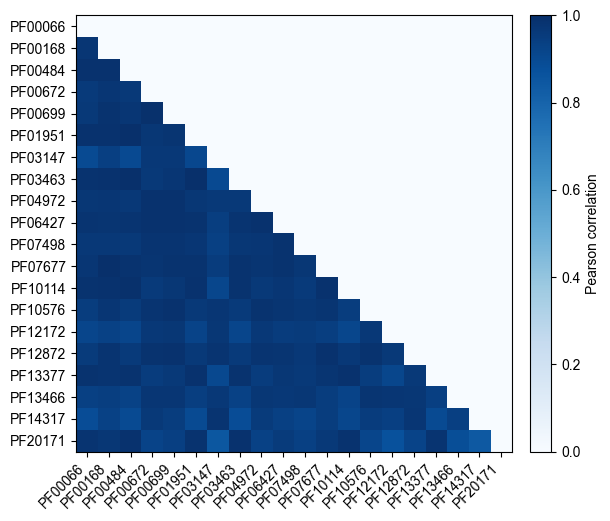

In [3]:
def correlated_simi(protein_domain, metrics):

    """Loads attention score data for default, shuffled column, and shuffled covariance MSAs from a specified base path."""

    base_path = 'score'
    default_file_name = 'attn_score.csv'
    default_file_path = os.path.join(base_path, default_file_name)

    if not os.path.exists(default_file_path):
        raise FileNotFoundError(f"{default_file_path} doesn't exist!")

    # Load default MSA data
    attn_data = pd.read_csv(default_file_path)
    attn_data['ProteinDomain'] = attn_data['FileName'].str.extract(r'(PF\d+)_')
    attn_data['Layers'] = attn_data['FileName'].str.extract('default_(\d+)_')[0].astype(int)
    attn_data['Heads'] = attn_data['FileName'].str.extract('default_\d+_(\d+)')[0].astype(int)
    attn_data = attn_data.sort_values(by=['ProteinDomain', 'Layers', 'Heads']).drop(['FileName'], axis=1)
    attn_data = attn_data.reindex(columns=['ProteinDomain', 'Layers', 'Heads',
                                           'NJRFScore', 'MLRFScore', 'NJCI', 'MLCI'])
    attn_data = attn_data[attn_data['ProteinDomain'] == protein_domain]
    val = attn_data[metrics].to_numpy()

    return val

def cal_pearsons(metrics):

  pearsons_coeffs = []
  for i, pfam_family_x in enumerate(protein_domain_list):
    for pfam_family_y in protein_domain_list[i + 1:]:
        x = correlated_simi(pfam_family_x, metrics).flatten()
        y = correlated_simi(pfam_family_y, metrics).flatten()

        pearsons_coeffs.append(pearsonr(x, y)[0])

  pearsons_coeffs = squareform(np.array(pearsons_coeffs))

  return pearsons_coeffs


with open('./data/Pfam/protein_domain.txt', 'r') as file:
  lines = file.readlines()
protein_domain_list = [line.strip() for line in lines]
pearsons_coeffs2 = cal_pearsons('NJRFScore')

labels = [pfam_family for i, pfam_family in enumerate(protein_domain_list)]

plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = ['arial']
fig, ax = plt.subplots(figsize=(6, 6),
                       constrained_layout=True)
im = ax.imshow(np.tril(pearsons_coeffs2),
               cmap='Blues',
               aspect="equal",
               vmin=0, vmax=1)
ax.set_yticks(np.arange(len(protein_domain_list)),
              labels=labels)
ax.set_xticks(np.arange(len(protein_domain_list)),
              labels=labels,
              rotation=45,
              ha="right")
fig.colorbar(im, ax=ax, fraction=0.05, pad=0.04, label="Pearson correlation")

plt.show()

## The similarity heatmap more closely correlated with Spearman's rho heatmapthan the regression coefficient heatmap.

In [39]:
def load_data(domain_name):
  ev_corr = correlated_rho(domain_name)
  simi_score = correlated_simi(domain_name, 'NJCI')

  return ev_corr, simi_score


def cal_pearsons(corr, simi_score):
  pearsons = pearsonr(corr.flatten(), simi_score.flatten())[0]

  return pearsons

pearsons_evo_list = []
pearsons_coeffs_list = []

for i, pfam_family in enumerate(protein_domain_list):
  ev_corr, simi_score = load_data(pfam_family)
  coeff = pd.read_csv('regr.csv')[pfam_family].to_numpy()

  pearsons_evo = cal_pearsons(ev_corr, simi_score)
  pearsons_coeffs = cal_pearsons(coeff, simi_score)
  pearsons_evo_list.append(pearsons_evo)
  pearsons_coeffs_list.append(pearsons_coeffs)

In [40]:
pearsons_evo_list

[0.7355256389371057,
 0.5090418704478449,
 0.8090685802036732,
 0.5495922920820756,
 0.7034874880306141,
 0.6518564893075436,
 0.5295835405942066,
 0.726899222360903,
 0.6744668955494499,
 0.6487062620295088,
 0.6759121699098234,
 0.7125804528502084,
 0.5698132967365569,
 0.7461483332313958,
 0.6035371806193269,
 0.7724633542016595,
 0.6137780772480297,
 0.7115213520768311,
 0.6014162120715699,
 0.7059068973495438]

In [41]:
pearsons_coeffs_list

[0.5935869933771052,
 0.5490143333507778,
 0.5785171092958193,
 0.467405484474379,
 0.509879248430838,
 0.5663880740446637,
 0.3687247308439118,
 0.4887398992504412,
 0.45946074874059073,
 0.65144377563707,
 0.5393227787783998,
 0.6329625724363679,
 0.4263510321802594,
 0.30823893207381897,
 0.35267561257254143,
 0.5417027480047908,
 0.24206783699431808,
 0.14525711377336537,
 0.3500708567750426,
 0.35626289334789163]